## Extractive Summarization Inference 

In this notebook we will 

- Load a pretrained Pytorch model for extractive summarization 
- Perform inference and visualize sentence scores.

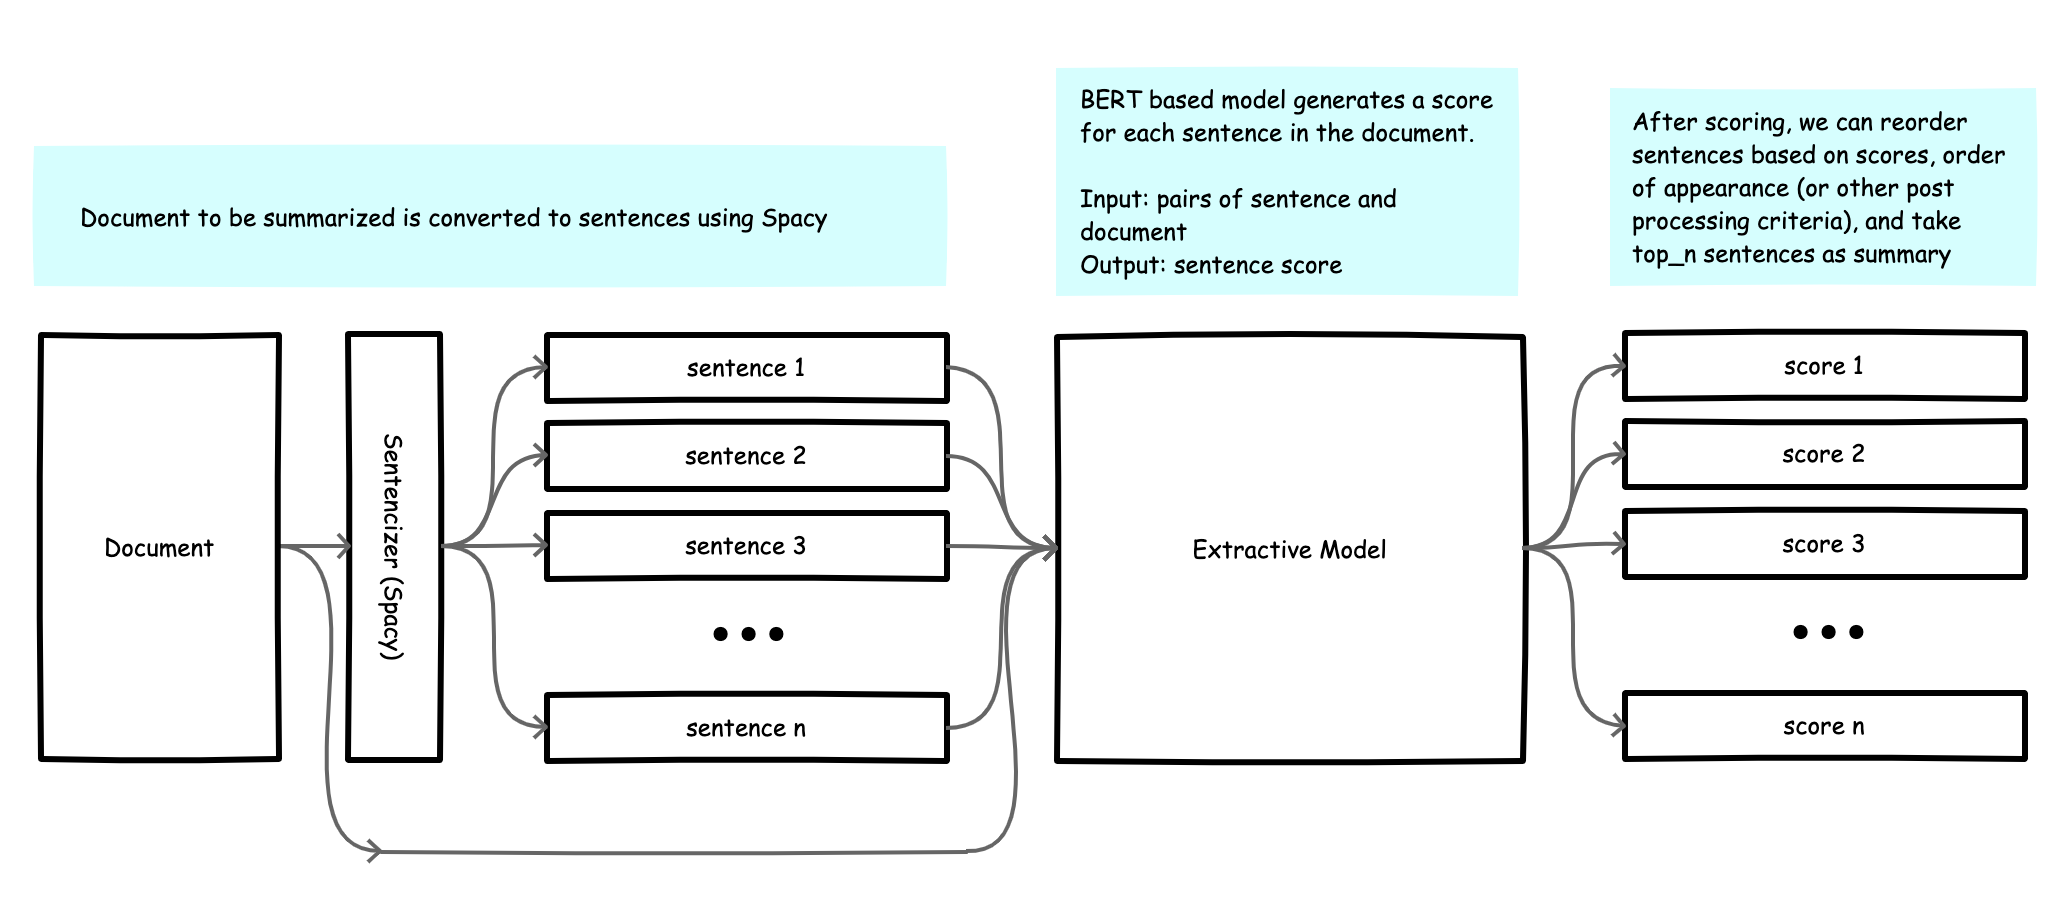

In [ ]:
!python -m spacy download en_core_web_lg

     |███████▎                        | 189.3 MB 1.7 MB/s eta 0:06:17

In [1]:
!pip install -q transformers  rouge-score sentence-transformers

In [62]:
 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
from tqdm.notebook import tqdm
 
import plotly.express as px

import os 
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
 
nlp = spacy.load('en_core_web_lg')

In [73]:
# get mean pooling for sentence bert models 
# ref https://www.sbert.net/examples/applications/computing-embeddings/README.html#sentence-embeddings-with-transformers
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask


# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class SentenceBertClass(torch.nn.Module):
    def __init__(self, model_name="sentence-transformers/paraphrase-MiniLM-L3-v2"):
        super(SentenceBertClass, self).__init__()
        self.l1 = AutoModel.from_pretrained(model_name)
        self.pre_classifier = torch.nn.Linear(384*3, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 1)
        self.classifierSigmoid = torch.nn.Sigmoid()

    def forward(self, sent_ids, doc_ids, sent_mask, doc_mask):

        sent_output = self.l1(input_ids=sent_ids, attention_mask=sent_mask) 
        sentence_embeddings = mean_pooling(sent_output, sent_mask) 

        doc_output = self.l1(input_ids=doc_ids, attention_mask=doc_mask) 
        doc_embeddings = mean_pooling(doc_output, doc_mask)

        # elementwise product of sentence embs and doc embs
        combined_features = sentence_embeddings * doc_embeddings  

        # get concat of both features and elementwise product
        feat_cat = torch.cat((sentence_embeddings, doc_embeddings, combined_features), dim=1)  
        
        pooler = self.pre_classifier(feat_cat) 
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        output = self.classifierSigmoid(output) 

        return output

In [74]:
#model path .. modify to location of trained model file 
model_path = "drive/MyDrive/mlexperiments/extractivesummarization/models/minilm_bal_exsum.pth"

In [75]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

model = SentenceBertClass() 
model.load_state_dict(torch.load(model_path, map_location=torch.device(device) ))
model.eval(); 

## Extractive Summarization Inference 



In [76]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-MiniLM-L3-v2')

def get_tokens(text, tokenizer):
  inputs = tokenizer.batch_encode_plus(
            text, 
            add_special_tokens=True,
            max_length=512,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
  ids = inputs['input_ids']
  mask = inputs['attention_mask']
  return ids, mask

In [77]:
def predict(sents, doc):
  sent_id, sent_mask = get_tokens(sents,tokenizer)
  sent_id, sent_mask = torch.tensor(sent_id, dtype=torch.long),torch.tensor(sent_mask, dtype=torch.long)
 
  doc_id, doc_mask = get_tokens([doc],tokenizer)
  doc_id, doc_mask = doc_id * len(sents), doc_mask* len(sents)
  doc_id, doc_mask = torch.tensor(doc_id, dtype=torch.long),torch.tensor(doc_mask, dtype=torch.long)

  preds = model(sent_id, doc_id, sent_mask, doc_mask)
  return preds

In [78]:
def summarize(doc, model, min_sentence_length=14, top_k=4, batch_size=3):
  doc_sentences = []
  for sent in nlp(doc).sents:
    if len(sent) > min_sentence_length: 
      doc_sentences.append(str(sent))
  
  doc_id, doc_mask = get_tokens([doc],tokenizer)
  doc_id, doc_mask = doc_id * batch_size, doc_mask* batch_size
  doc_id, doc_mask = torch.tensor(doc_id, dtype=torch.long),torch.tensor(doc_mask, dtype=torch.long)

  scores = [] 
  # run predictions using some batch size
  for i in tqdm(range(int(len(doc_sentences) / batch_size) + 1)):
    preds = predict(doc_sentences[i*batch_size: (i+1) * batch_size], doc) 
    scores = scores + preds.tolist() 
 
  sent_pred_list = [{"sentence": doc_sentences[i], "score": scores[i][0], "index":i} for i in range(len(doc_sentences))]
  sorted_sentences = sorted(sent_pred_list, key=lambda k: k['score'], reverse=True) 

  sorted_result = sorted_sentences[:top_k] 
  sorted_result = sorted(sorted_result, key=lambda k: k['index']) 
  
  summary = [ x["sentence"] for x in sorted_result]
  summary = " ".join(summary)

  return summary, scores, doc_sentences


In [79]:
article = """ Birds are a group of warm-blooded vertebrates constituting the class Aves /ˈeɪviːz/, characterised by feathers, toothless beaked jaws, the laying of hard-shelled eggs, a high metabolic rate, a four-chambered heart, and a strong yet lightweight skeleton. Birds live worldwide and range in size from the 5.5 cm (2.2 in) bee hummingbird to the 2.8 m (9 ft 2 in) ostrich. There are about ten thousand living species, more than half of which are passerine, or “perching” birds. Birds have wings whose development varies according to species; the only known groups without wings are the extinct moa and elephant birds. Wings, which evolved from forelimbs, gave birds the ability to fly, although further evolution has led to the loss of flight in some birds, including ratites, penguins, and diverse endemic island species. The digestive and respiratory systems of birds are also uniquely adapted for flight. Some bird species of aquatic environments, particularly seabirds and some waterbirds, have further evolved for swimming. Birds are feathered theropod dinosaurs and constitute the only known living dinosaurs. Likewise, birds are considered reptiles in the modern cladistic sense of the term, and their closest living relatives are the crocodilians. Birds are descendants of the primitive avialans (whose members include Archaeopteryx) which first appeared about 160 million years ago (mya) in China. According to DNA evidence, modern birds (Neornithes) evolved in the Middle to Late Cretaceous, and diversified dramatically around the time of the Cretaceous–Paleogene extinction event 66 mya, which killed off the pterosaurs and all known non-avian dinosaurs. Many social species pass on knowledge across generations, which is considered a form of culture. Birds are social, communicating with visual signals, calls, and songs, and participating in such behaviours as cooperative breeding and hunting, flocking, and mobbing of predators. The vast majority of bird species are socially (but not necessarily sexually) monogamous, usually for one breeding season at a time, sometimes for years, but rarely for life. Other species have breeding systems that are polygynous (one male with many females) or, rarely, polyandrous (one female with many males). Birds produce offspring by laying eggs which are fertilised through sexual reproduction. They are usually laid in a nest and incubated by the parents. Most birds have an extended period of parental care after hatching. Many species of birds are economically important as food for human consumption and raw material in manufacturing, with domesticated and undomesticated birds being important sources of eggs, meat, and feathers. Songbirds, parrots, and other species are popular as pets. Guano (bird excrement) is harvested for use as a fertiliser. Birds figure throughout human culture. About 120 to 130 species have become extinct due to human activity since the 17th century, and hundreds more before then. Human activity threatens about 1,200 bird species with extinction, though efforts are underway to protect them. Recreational birdwatching is an important part of the ecotourism industry. """

In [80]:
article

' Birds are a group of warm-blooded vertebrates constituting the class Aves /ˈeɪviːz/, characterised by feathers, toothless beaked jaws, the laying of hard-shelled eggs, a high metabolic rate, a four-chambered heart, and a strong yet lightweight skeleton. Birds live worldwide and range in size from the 5.5 cm (2.2 in) bee hummingbird to the 2.8 m (9 ft 2 in) ostrich. There are about ten thousand living species, more than half of which are passerine, or “perching” birds. Birds have wings whose development varies according to species; the only known groups without wings are the extinct moa and elephant birds. Wings, which evolved from forelimbs, gave birds the ability to fly, although further evolution has led to the loss of flight in some birds, including ratites, penguins, and diverse endemic island species. The digestive and respiratory systems of birds are also uniquely adapted for flight. Some bird species of aquatic environments, particularly seabirds and some waterbirds, have furt

## Inference and Visualization of Sentence Scores

- Perform inference
- Make sense of model results by visualizing scores assigned to each sentence.

In [81]:
summary, scores, sentences = summarize(article, model, min_sentence_length=14, top_k=3, batch_size=4)
summary

  0%|          | 0/5 [00:00<?, ?it/s]

'Birds live worldwide and range in size from the 5.5 cm (2.2 in) bee hummingbird to the 2.8 m (9 ft 2 in) ostrich. 66 mya, which killed off the pterosaurs and all known non-avian dinosaurs. Human activity threatens about 1,200 bird species with extinction, though efforts are underway to protect them.'

In [82]:
score_vals = [x[0] for x in scores]  
sub_sents = [ x[:50] + " ..  " for x in sentences]
pdf = pd.DataFrame.from_dict({"scores":score_vals, "sentences": sentences, "captions": sub_sents})

fig = px.bar(pdf, x="scores", y="captions", orientation='h', title="Article Summary", hover_data=["sentences"])
fig.show()